# Tutorial 05: collision checks with dynamic obstacles

The drivability checker library provides functionality to quickly check if the ego-vehicle collides with a set of dynamic obstacles. These could be, e.g., trajectory predictions for other trafic participants or the drivable area for other traffic participants.


## 1 Helper functions

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from time import time

# commonroad
from commonroad.geometry.shape import Polygon, ShapeGroup, Shape, Rectangle
from commonroad.scenario.lanelet import LaneletNetwork
from commonroad.scenario.obstacle import StaticObstacle, ObstacleType
from commonroad.scenario.scenario import Scenario
from commonroad.scenario.trajectory import State, Trajectory
from commonroad.prediction.prediction import TrajectoryPrediction, SetBasedPrediction

#commonroad-io
from commonroad.common.file_reader import CommonRoadFileReader

# commonroad_dc
import commonroad_dc.pycrcc as pycrcc
from commonroad_dc.collision.collision_detection.pycrcc_collision_dispatch import create_collision_checker, create_collision_object
from commonroad_dc.collision.visualization.draw_dispatch import draw_object
from commonroad_dc.boundary import boundary
from commonroad_dc.collision.trajectory_queries import trajectory_queries
from commonroad_dc.pycrcc.Util import trajectory_enclosure_polygons_static
import commonroad_dc.pycrcc.Util as Util

def open_scenario(scenario_filename):

    crfr = CommonRoadFileReader(
        scenario_filename)
    scenario, planning_problem_set = crfr.open()
    return scenario, planning_problem_set


directory = './'

## 2 Collision checks

/home/rusinovv/.conda/envs/new9/lib/python3.7/site-packages/commonroad_io-2020.2-py3.7.egg/commonroad/visualization/scenario.py:1012: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  tmp_array  = np.array(list(map(collecting,obj)))


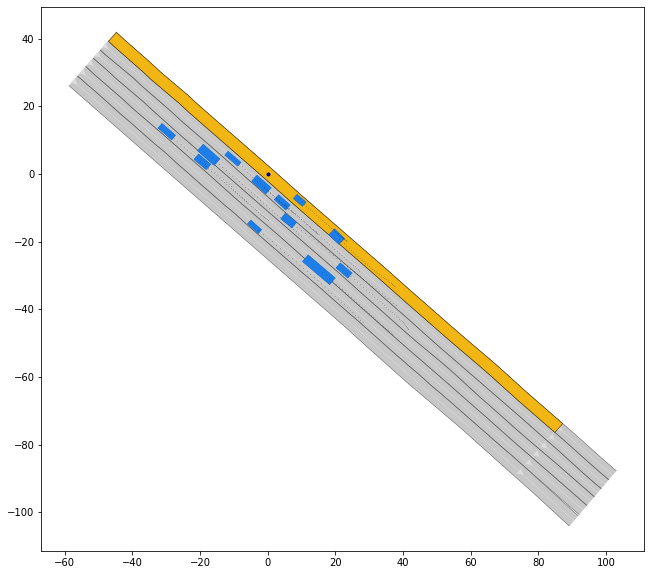

In [2]:
scenario_name_set_prediction="USA_US101-3_3_S-1"
scenario_name_trajectory_prediction="USA_US101-3_3_T-1"


#open the example scenario
scenario, planning_problem_set = open_scenario(directory+scenario_name_trajectory_prediction+'.xml')


# plot the scenario
plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(planning_problem_set)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

In [3]:
def load_waypoints(scenario_name):

    try:
        data=np.load("./"+scenario_name+"_waypoints.npz")
    except:
        return None
    
    loaded={"car_shape": data["car_shape"], "trajectories": data["trajectories"], "start_time_step": data["start_time_step"]}

    data.close()
    
    trajectory_list=list()

    start_time_step=loaded["start_time_step"]
    
    for ind,ts_start_idx in enumerate(start_time_step):
        tvobstacle=pycrcc.TimeVariantCollisionObject(int(ts_start_idx))
        car_half_length,car_half_width=loaded["car_shape"]/2
        for state in loaded["trajectories"][ind]:
            tvobstacle.append_obstacle(pycrcc.RectOBB(car_half_length, car_half_width, state[2], state[0], state[1]))
        
        tvobstacle, err=trajectory_queries.trajectory_preprocess_obb_sum(tvobstacle)
    
        trajectory_list.append(tvobstacle)
    
    return trajectory_list, loaded



In [4]:
trajectories, loaded = load_waypoints(scenario_name_trajectory_prediction)

waypoints=loaded["trajectories"]

car_shape=loaded["car_shape"]
car_half_length, car_half_width = (car_shape/2)

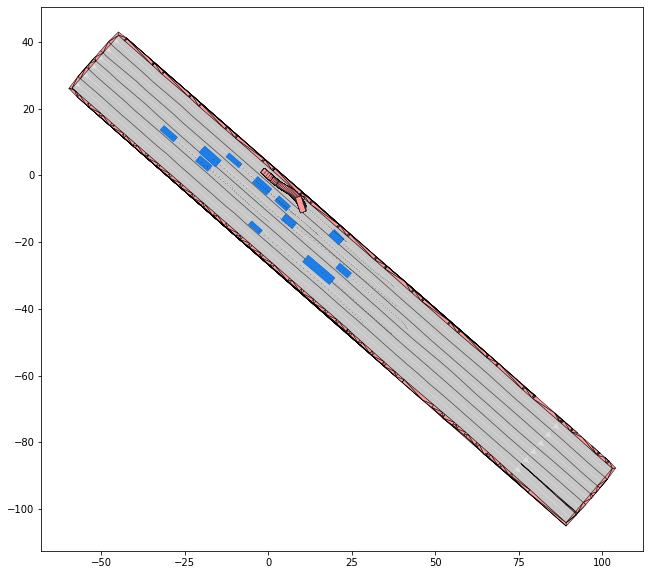

In [5]:
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
road_polygons = boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)

#draw 50 trajectories

n_traj_draw=50
offset=350

plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(road_boundary_sg_triangles)

draw_object(trajectories[offset:offset+n_traj_draw])
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

## 2.1 Check if trajectory is within the road

## 2.1.1 Triangulation

In [6]:
num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(waypoints):
        if trajectory_enclosure_polygons_static(road_polygons,car_half_length, car_half_width, el[0:0])==-1:    
            candidate_trajectories.append(trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_triangles, method='grid', num_cells=32, auto_orientation=True, optimize_triangles=True)

    
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")


Time for 1000 trajectory checks: 0.01904280185699463 sec.


## 2.1.2 OBB rectangles

In [7]:
road_boundary_sg_rectangles = boundary.create_road_boundary_obstacle(scenario, method='obb_rectangles', return_scenario_obstacle=False)

num_trials=10

from time import time
cur_time_1=time()
for i in range(num_trials):
    candidate_trajectories=list()
    for ind,el in enumerate(waypoints):
        if trajectory_enclosure_polygons_static(road_polygons,car_half_length, car_half_width, el[0:0])==-1:    
            candidate_trajectories.append(trajectories[ind])
    ret=trajectory_queries.trajectories_collision_static_obstacles(candidate_trajectories, road_boundary_sg_rectangles, method='grid', num_cells=32, auto_orientation=True, optimize_triangles=True)

    
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")

Time for 1000 trajectory checks: 0.008930253982543945 sec.


## 2.2 Collisions between ego-vehicle trajectories and trajectory predictions

In [8]:
def get_scenario_dynamic_obstacles_list(scenario):
    dyn_obstacles_list=list()

    for dyn_obst in scenario.dynamic_obstacles:
        if isinstance(dyn_obst.prediction,TrajectoryPrediction):
            co=create_collision_object(dyn_obst.prediction)
            co, err=trajectory_queries.trajectory_preprocess_obb_sum(co)
            dyn_obstacles_list.append(co)
        else:
            if isinstance(dyn_obst.prediction,SetBasedPrediction):
                co=create_collision_object(dyn_obst.prediction)
                dyn_obstacles_list.append(co)    
            else:
                raise Exception('Unknown dynamic obstacle prediction type: ' + str(type(dyn_obst.prediction))) 
    return dyn_obstacles_list

In [9]:
dynamic_obstacles=get_scenario_dynamic_obstacles_list(scenario)

In [10]:
num_trials=10
cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, dynamic_obstacles, method='box2d')
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")
res_dynamic=np.asarray(res_dynamic)

Time for 1000 trajectory checks: 0.0073821783065795895 sec.


## 2.3 Collisions between ego-vehicle trajectories and set-based predictions

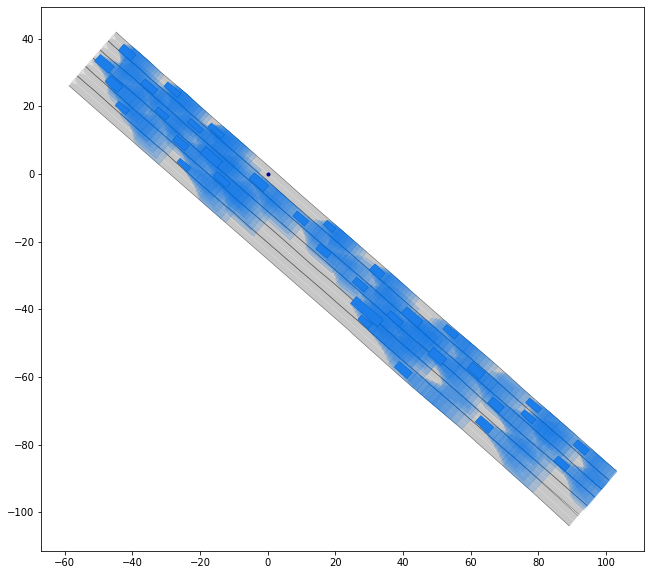

In [11]:
#open the example scenario
scenario, planning_problem_set = open_scenario(directory+scenario_name_set_prediction+'.xml')


# plot the scenario
plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(planning_problem_set)
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

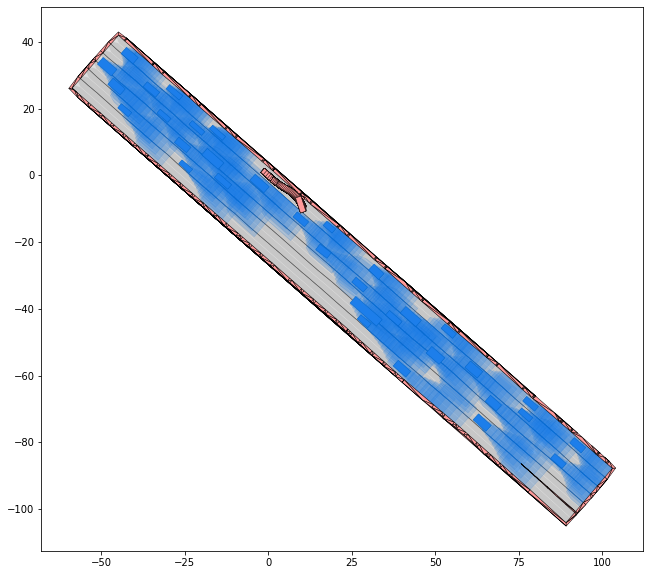

In [12]:
road_boundary_obstacle, road_boundary_sg_triangles=boundary.create_road_boundary_obstacle(scenario, method='triangulation')
road_polygons = boundary.create_road_polygons(scenario, method='whole_polygon', triangulate=False)
    
#draw 50 trajectories

n_traj_draw=50
offset=350

plt.figure(figsize=(25, 10))
draw_object(scenario)
draw_object(road_boundary_sg_triangles)

draw_object(trajectories[offset:offset+n_traj_draw])
plt.autoscale()
plt.gca().set_aspect('equal')
plt.show()

In [13]:
dynamic_obstacles=get_scenario_dynamic_obstacles_list(scenario)


In [14]:
num_trials=10
cur_time_1=time()
for i in range(num_trials):
    res_dynamic = trajectory_queries.trajectories_collision_dynamic_obstacles(trajectories, dynamic_obstacles, method='grid')
cur_time_2 = time()
print("Time for 1000 trajectory checks: " + str((cur_time_2-cur_time_1)/num_trials)+ " sec.")
res_dynamic=np.asarray(res_dynamic)

Time for 1000 trajectory checks: 0.00841062068939209 sec.
